# Libraries import

In [1]:
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings('ignore',category=NumbaDeprecationWarning)

In [2]:
from SIReNet.epidemics_graph import EpidemicsGraph

# Graph initialization

In [3]:
!pwd

/home/mrcharles/SIReNet_project


In [4]:
city = EpidemicsGraph(pop_size=1000)
city.sampler_initializer()

In [5]:
city.create_families()

In [6]:
city.adjacency

<1000x1000 sparse matrix of type '<class 'numpy.bool_'>'
	with 2030 stored elements in Dictionary Of Keys format>

In [7]:
city.add_links(get_richer_step=1)

/home/mrcharles/SIReNet_project/SIReNet/sparse_graph.py:175: UserWarning: Numerical error occurred, remaning links 41
  warnings.warn('Numerical error occurred, remaning links {}'.format(links - added))


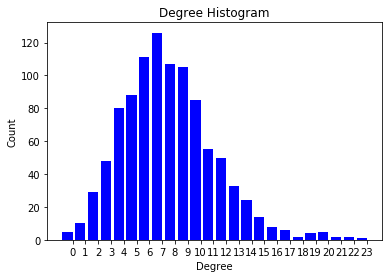

In [8]:
city.build_nx_graph()
city.degree_distribution()

In [9]:
city.components_dimension()[:10]

[995, 1, 1, 1, 1, 1]

In [10]:
city.compute_common_neighbors()

<1000x1000 sparse matrix of type '<class 'numpy.int16'>'
	with 69280 stored elements in Dictionary Of Keys format>

# Dynamics

In [11]:
city.initialize_individual_factors()

In [12]:
city.start_infection(contagion_probability=0.05)

39 people have been infected


In [13]:
for i in range(50):
    city.propagate_infection(mu=2,time_resolution=1)

#city.propagation_stats()

-- EPIDEMICS --
Actual number of infect people: 329
New Recovered: 0
New Deaths: 0
New Infects: 0.0


-- MODEL DYNAMICS --
- Scores
Min score: 0.0
Max score: 15.0
Mean score: 1.658
Variance: 6.425461461461461
Skewness: 1.911187506105867


15th percentile: 0.0
25th percentile: 0.0
50th percentile: 0.0
75th percentile: 3.0
90th percentile: 5.0


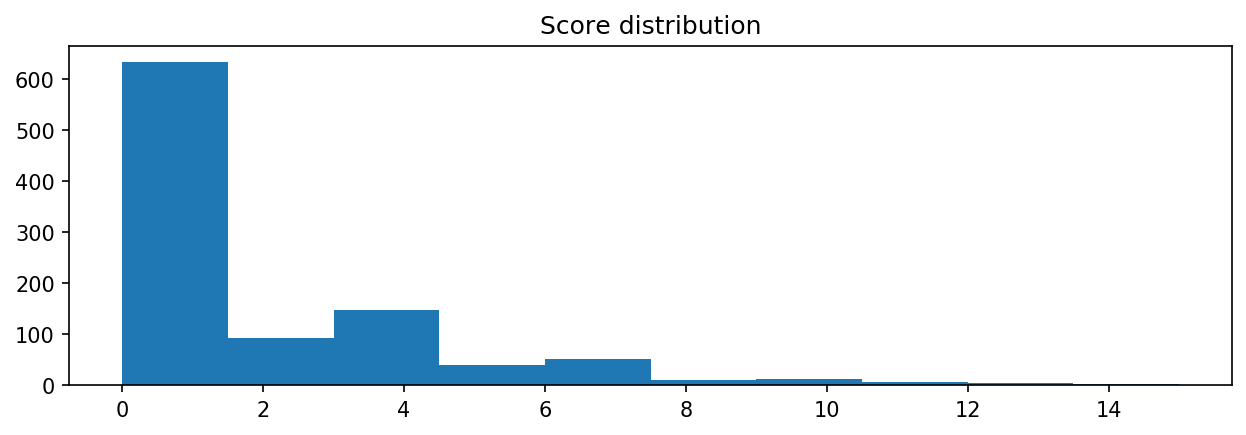



- Probs
Min score: 0.0
Max score: 0.9999999995200317
Mean score: 0.2865795250186523
Variance: 0.1754349441095484
Skewness: 0.8422901465964884


15th percentile: 0.0
25th percentile: 0.0
50th percentile: 0.0
75th percentile: 0.857123460498547
90th percentile: 0.9834363915193856


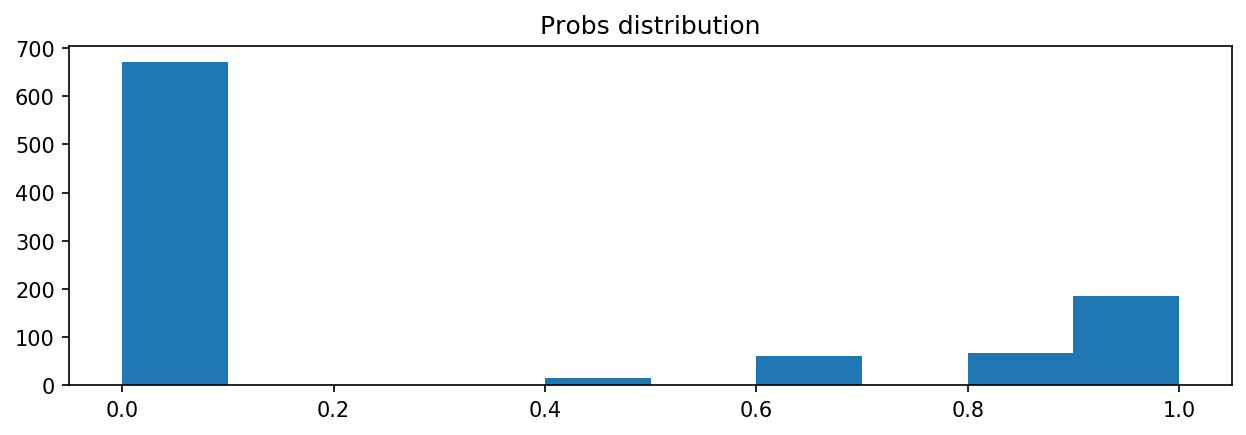

In [14]:
city.propagation_stats()

In [15]:
city.export_graph()

/home/mrcharles/SIReNet_project/adjacency.npz


In [16]:
city.infect_over_time

array([ 39.,  54., 117., 203., 261., 348., 378., 354., 341., 336., 333.,
       339., 333., 333., 331., 332., 333., 331., 331., 331., 330., 330.,
       330., 329., 329., 329., 329., 329., 332., 329., 329., 329., 330.,
       329., 330., 329., 330., 329., 329., 329., 329., 329., 329., 329.,
       329., 329., 329., 329., 329., 329., 329.])

In [17]:
print(len(city.infect_over_time))
print(len(city.recovery_over_time))
print(len(city.death_over_time))

51
51
51


In [18]:
city.death_over_time

array([ 0.,  8.,  7., 16., 26., 18., 17., 21.,  8.,  5.,  1.,  3.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

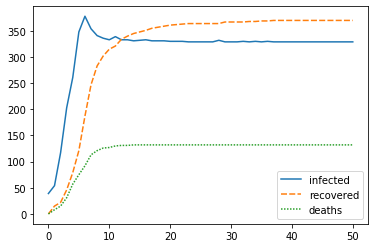

In [19]:
city.iterations_summary()

In [20]:
len(city.infect_probs_over_time)

50

In [21]:
from scipy import stats
import numpy as np


lower_quant = []
median = []
upper_quant = []

for i in range(50):
    
    prob_quantiles =np.percentile(city.infect_probs_over_time[i], [15, 25, 50, 75, 90])
    
    lower_quant.append(prob_quantiles[1])
    median.append(prob_quantiles[2])
    upper_quant.append(prob_quantiles[3])
    

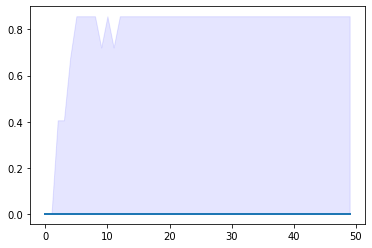

In [22]:
import matplotlib.pyplot as plt
plt.plot(median, linewidth=2)  # mean curve.
plt.fill_between(list(range(50)),lower_quant, upper_quant, color='b', alpha=.1)


# Neural net

In [15]:
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler

import time
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim

from pygcn.utils import load_data, accuracy
from pygcn.models import GCN
from pygcn.utils import normalize
from pygcn.utils import  sparse_mx_to_torch_sparse_tensor

from SIReNet.utils import  IndexSampler

In [16]:
torch.cuda.get_device_name()

'GeForce RTX 2070'

In [17]:
#fix seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [18]:
#load exported data
adj = sp.load_npz('adjacency.npz')
adj = normalize(adj)

features = pd.read_csv('node_features.csv')
indexes = features.index.values
labels = features['labels'].values

print(np.sum(labels)/labels.shape[0])

features = features.drop(['labels'],axis=1)
feature_transformer =  StandardScaler()
features = feature_transformer.fit_transform(features)

features = torch.FloatTensor(features)
labels = torch.LongTensor(labels)
adj = sparse_mx_to_torch_sparse_tensor(adj)


print(len(indexes))

0.5714923374497842
6721


In [19]:
#indexes
idx_sampler = IndexSampler(indexes)
idx_train = torch.LongTensor(idx_sampler.sample(n_samples=2000))
idx_val = torch.LongTensor(idx_sampler.sample(n_samples=1000))
idx_test = torch.LongTensor(idx_sampler.sample_remaining())

4721
3721


In [24]:
print(adj.shape)
print(features.shape)
print(labels.shape)
print(idx_train.shape)
print(idx_val.shape)
print(idx_test.shape)

torch.Size([5327, 5327])
torch.Size([5327, 3])
torch.Size([5327])
torch.Size([2000])
torch.Size([1000])
torch.Size([2327])


In [25]:
#model
model = GCN(nfeat=features.shape[1],
            nhid=16,
            nclass=labels.max().item() + 1,
            dropout=0.5)
optimizer = optim.Adam(model.parameters(),
                       lr=0.01, weight_decay=5e-4)

In [26]:
#move tensors to cuda
model.cuda()
features = features.cuda()
adj = adj.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()

In [27]:
#Training
fastmode = False

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))


# Train model
t_total = time.time()
for epoch in range(200):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()

Epoch: 0001 loss_train: 0.8819 acc_train: 0.4140 loss_val: 0.8764 acc_val: 0.3880 time: 0.3402s
Epoch: 0002 loss_train: 0.8556 acc_train: 0.4140 loss_val: 0.8506 acc_val: 0.3880 time: 0.0031s
Epoch: 0003 loss_train: 0.8294 acc_train: 0.4140 loss_val: 0.8262 acc_val: 0.3880 time: 0.0030s
Epoch: 0004 loss_train: 0.8112 acc_train: 0.4135 loss_val: 0.8031 acc_val: 0.3880 time: 0.0028s
Epoch: 0005 loss_train: 0.7897 acc_train: 0.4140 loss_val: 0.7813 acc_val: 0.3880 time: 0.0030s
Epoch: 0006 loss_train: 0.7701 acc_train: 0.4130 loss_val: 0.7606 acc_val: 0.3880 time: 0.0030s
Epoch: 0007 loss_train: 0.7545 acc_train: 0.4125 loss_val: 0.7410 acc_val: 0.3880 time: 0.0029s
Epoch: 0008 loss_train: 0.7377 acc_train: 0.4165 loss_val: 0.7224 acc_val: 0.3880 time: 0.0030s
Epoch: 0009 loss_train: 0.7163 acc_train: 0.4265 loss_val: 0.7048 acc_val: 0.3880 time: 0.0030s
Epoch: 0010 loss_train: 0.7055 acc_train: 0.4450 loss_val: 0.6882 acc_val: 0.3950 time: 0.0030s
Epoch: 0011 loss_train: 0.6918 acc_train